<a href="https://colab.research.google.com/github/emm32449/MCTS-in-Python/blob/main/MCTS_in_Python_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

help me code my version of alpha go zero for a small game:


Modifications for MCTS in Python 5:

Simulation: Instead of simulating games to the end, we can use the neural network to evaluate the game state and estimate the value and policy. This can be done in the selection method of your MCTS class.

Training: We can use the improved move probabilities from MCTS as targets to train the neural network. This can be done in the train method of your MCTS class.

MCTS in Python 6:

Your self_play function seems to be logically correct, but there are a few potential issues that might cause unexpected behavior:

Random Simulation: In the line where you perform the simulation, you’re randomly choosing a child node for the simulation. This might not be ideal because it doesn’t take into account the potential value of each child node. Instead, you might want to use the policy predicted by your network to guide the simulation.

Policy Calculation: You’re calculating the policy based on the visit counts of the children nodes. However, this policy is not being used anywhere in the MCTS process. Instead, you’re using a random action selection based on the visit counts. You might want to use this policy to guide the selection process in MCTS.

Action Selection: You’re using torch.multinomial to select an action, which introduces randomness into the action selection process. This is generally a good approach for encouraging exploration during training, but you **might want to use a more deterministic action selection strategy during evaluation (e.g., choosing the action with the highest visit count or highest value).**

Reward Calculation: You’re getting the reward from the final state after the game has ended. However, this reward is not being backpropagated up the tree. You might want to include a backpropagation step after the game ends to update the value estimates of the nodes.

Root Initialization: You’re creating a new root node for each move. This means that the tree is discarded after each move, and the MCTS starts from scratch. This could be inefficient, especially if num_simulations is large. An alternative approach is to keep the subtree corresponding to the chosen action and use it as the new tree for the next move.

In [1]:
# Assume we have a simple game state
class GameState:
    def __init__(self, state):
        self.state = state

    def __str__(self):
        return str(self.state)

    def get_legal_moves(self):
        return [1, 2, 3]

    def get_initial_state(self):
        return GameState(0)

    def make_move(self, move):
        return GameState(self.state + move)

    def is_terminal(self):
        return self.state >= 10

    def get_reward(self):
        # Give a positive reward if the state is exactly 10
        if self.state == 10:
            return 1
        # Give a negative reward if the state exceeds 10
        elif self.state > 10:
            return -1
        # Give a reward based on how close the state is to 10
        else:
            return 1 - abs(self.state - 10) / 10

    def reset(self):
        self.state = 0

    def copy(self):
        return GameState(self.state)

    def to_array(self):
        return [self.state]

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import random

class Node:
    def __init__(self, game_state, policy, parent=None, move=None):
        self.game_state = game_state
        self.policy = policy
        self.parent = parent
        self.move = move
        self.children = []
        self.visits = 0
        self.wins = 0

    def __str__(self):
        return f"GameState: {self.game_state}, Move: {self.move}, Visits: {self.visits}, Wins: {self.wins}"

class MCTS:
    def __init__(self, model, root):
        self.model = model
        self.root = root
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)

    def choose_action(self, node):
        # Choose the action that leads to the child with the most visits
        max_visits = -math.inf
        chosen_action = None
        for child in node.children:
            if child.visits > max_visits:
                max_visits = child.visits
                chosen_action = child.move
        return chosen_action

    def selection(self, node):
        # While the current node has children (i.e., it's not a leaf node)
        while len(node.children) > 0:
            # Initialize the maximum value and the selected node
            max_value = -math.inf
            selected_node = None

            # Loop over each child of the current node
            for child in node.children:
                # Convert the game state to a tensor
                state_tensor = torch.tensor(node.game_state.to_array(), dtype=torch.float32)
                # Use the neural network to evaluate the game state and estimate the policy and value
                policy, value = self.model(state_tensor)

                # Compute the Q-value (average reward) of the child node
                Q = child.wins / child.visits if child.visits != 0 else 0
                # Compute the U-value (exploration term) of the child node
                U = policy.mean() * math.sqrt(node.visits) / (1 + child.visits)
                # The value of the node is the sum of the Q-value and U-value
                node_value = Q + U

                # If the node's value is greater than the current maximum value
                if node_value > max_value:
                    # Update the maximum value and the selected node
                    max_value = node_value
                    selected_node = child

            # Move to the selected node
            node = selected_node

        # Return the final selected node
        return node

    def expansion(self, node):
        # Get the list of legal moves from the game state
        legal_moves = node.game_state.get_legal_moves()

        # For each legal move, create a new node and add it to the children of the current node
        for move in legal_moves:
            new_game_state = node.game_state.make_move(move)
            state_tensor = torch.tensor(new_game_state.to_array(), dtype=torch.float32)
            policy, value = self.model(state_tensor)
            child_node = Node(new_game_state, policy, parent=node, move=move)
            node.children.append(child_node)

        return node.children

    def simulation(self, node):
        # Make a copy of the game state
        game_state = node.game_state.copy()

        # While the game is not over
        while not game_state.is_terminal():

            # Get the list of legal moves
            legal_moves = game_state.get_legal_moves()

            # Choose a move randomly
            move = random.choice(legal_moves)

            # Apply the move to get the next game state
            game_state = game_state.make_move(move)

        # Return the reward associated with the terminal state
        return game_state.get_reward()

    def backpropagation(self, node, reward):
        # While node is not None
        while node is not None:
            # Update the visit count of the node
            node.visits += 1

            # Update the win count of the node
            node.wins += reward

            # Move to the parent node
            node = node.parent

    def run(self, simulations):
        for _ in range(simulations):
            # Start from the root node
            node = self.root

            # Selection
            node = self.selection(node)

            # Skip expansion, simulation, and backpropagation if a terminal node is selected
            if node.game_state.is_terminal():
                continue

            # Expansion
            if not node.game_state.is_terminal():
                node = random.choice(self.expansion(node))

            # Simulation
            reward = self.simulation(node)

            # Backpropagation
            self.backpropagation(node, reward)

            # Choose an action
            chosen_action = self.choose_action(node)

            # Get the list of children that match the chosen action
            matching_children = [child for child in node.children if child.move == chosen_action]

            # Check if there are any matching children
            if matching_children:
                # If there are, set the root to the first matching child
                self.root = matching_children[0]
            else:
                # If there are no matching children, handle the error appropriately
                print("No child found with the chosen action.")

    def print_tree(self, node, indent=""):
        print(indent + str(node))
        for child in node.children:
            self.print_tree(child, indent + "  ")

    def self_play(self, network, game, game_number, num_simulations=50):
        states = []
        policies = []
        current_state = game.get_initial_state()

        while not current_state.is_terminal():
            # Initialize the root node with the current state
            root = Node(current_state, None)

            # Perform MCTS simulations from the root
            for _ in range(num_simulations):
                leaf = self.selection(root)
                children = self.expansion(leaf)
                reward = self.simulation(random.choice(children))
                self.backpropagation(leaf, reward)

            # Get the visit counts of the root's children
            visit_counts = torch.tensor([child.visits for child in root.children]).float()

            # Convert the visit counts to a policy
            policy = F.softmax(visit_counts, dim=0).tolist()

            # Choose an action based on the policy
            action = root.children[torch.multinomial(visit_counts, 1).item()].move

            # Store the numerical representation of the state and policy
            states.append(current_state.to_array())
            policies.append(policy)

            # Apply the action to get the next state
            current_state = current_state.make_move(action)

        # Get the reward from the final state
        reward = current_state.get_reward()

        return states, policies, reward

    # Use the improved move probabilities from MCTS as targets to train the neural network
    # This function trains the neural network using the states, policies, and reward from self-play
    def train(self, states, policies, reward, epochs):
        # Convert the states, policies, and reward to PyTorch tensors
        states = torch.tensor(states, dtype=torch.float32)
        policies = torch.tensor(policies, dtype=torch.float32)
        result = torch.tensor([reward] * len(states), dtype=torch.float32).view(-1, 1)

        # Loop over the number of training epochs
        for _ in range(epochs):
            # Get the predicted policy and value from the network
            policy_pred, value_pred = self.model(states)

            # Compute the policy loss as the KL divergence between the predicted and target policy
            policy_loss = F.kl_div(F.log_softmax(policy_pred, dim=1), policies)
            # Compute the value loss as the mean squared error between the predicted and actual reward
            value_loss = F.mse_loss(value_pred, result)
            # The total loss is the sum of the policy loss and value loss
            loss = policy_loss + value_loss

            # Zero the gradients, perform backpropagation, and update the network parameters
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        # Return the final loss
        return loss.item()

In [3]:
class PolicyValueNet(nn.Module):
    def __init__(self, num_actions):
        super().__init__()
        self.hidden1 = nn.Linear(1, 64)
        self.hidden2 = nn.Linear(64, 64)

        # Policy Head forms probabilites for each action, distribution
        self.policy_head = nn.Linear(64, num_actions)

        # Value Head predicts winner of game from each position, scaler
        self.value_head = nn.Linear(64, 1)

    def forward(self, state):
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))
        policy = F.softmax(self.policy_head(x), dim=-1)
        value = torch.tanh(self.value_head(x))
        return policy, value

Initial Training Only

In [ ]:
# Create the game and network
game = GameState(0)
num_actions = len(game.get_legal_moves())
network = PolicyValueNet(num_actions)

# Create a uniform policy
uniform_policy = [1.0 / num_actions] * num_actions

root = Node(game.get_initial_state(), uniform_policy)

# Create the MCTS
mcts = MCTS(network, root)

# Initialize a list to store the losses
losses = []

# Set the model to training mode
network.train()

epochs = 50 # Play games
game_number = 1

# Generate self-play data and train the network
for i in range(epochs):
    states, actions, reward = mcts.self_play(network, game, game_number)
    loss = mcts.train(states, actions, reward, epochs)
    losses.append(loss)
    game_number += 1

Save

In [10]:
from google.colab import drive
drive.mount('/content/drive')

# Save the model, optimizer, game number, and losses
torch.save({
    'model_state_dict': network.state_dict(),
    'optimizer_state_dict': mcts.optimizer.state_dict(),
    'game_number': game_number,
    'losses': losses
}, '/content/drive/My Drive/MCTS in Python/MCTS_model.pth')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load & Continue

In [8]:
from google.colab import drive
drive.mount('/content/drive')

# Create the game and network
game = GameState(0)
num_actions = len(game.get_legal_moves())
network = PolicyValueNet(num_actions)

# Load the model, optimizer, game number, and losses
checkpoint = torch.load('/content/drive/My Drive/MCTS in Python/MCTS_model.pth')
network.load_state_dict(checkpoint['model_state_dict'])

# Create a uniform policy
uniform_policy = [1.0 / num_actions] * num_actions

root = Node(game.get_initial_state(), uniform_policy)

# Create the MCTS
mcts = MCTS(network, root)
mcts.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

game_number = checkpoint['game_number']
losses = checkpoint['losses']

# Set the model to training mode
network.train()

# Continue training for...<epochs> more games
epochs=1000

for _ in range(epochs):
    states, actions, reward = mcts.self_play(network, game, game_number)
    loss = mcts.train(states, actions, reward, epochs)
    losses.append(loss)
    game_number += 1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Plot

Average Loss: 0.24662748484313488, Max Loss: 3.7292094230651855, Min Loss: 0.06270544230937958


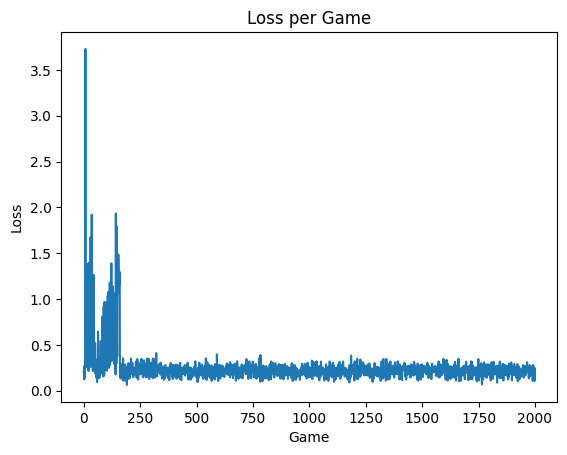

In [9]:
import matplotlib.pyplot as plt
# Print and plot the losses
print(f"Average Loss: {sum(losses) / len(losses)}, Max Loss: {max(losses)}, Min Loss: {min(losses)}")
plt.plot(losses)
plt.xlabel('Game')
plt.ylabel('Loss')
plt.title('Loss per Game')
plt.show()

Play, Eval()

In [ ]:
# Initialize a list to store the results of each game
win_rates = []

from google.colab import drive
drive.mount('/content/drive')

# See the model playout games using MCTS

# Load the model and optimizer
checkpoint = torch.load('/content/drive/My Drive/MCTS in Python/MCTS_model.pth')
network.load_state_dict(checkpoint['model_state_dict'])
mcts.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Set the model to evaluation mode
network.eval()

# Play # games
num_games = 50

for i in range(num_games):
    print(f"Game {i + 1}:")

    # Initialize the game and the root node
    game_state = game.get_initial_state()
    root = Node(game_state, None)

    #Make sure that the MCTS and the root node persist throughout each game
    mcts = MCTS(network, root)

    while not game_state.is_terminal():
        # Perform MCTS simulations from the root
        for _ in range(num_games):
            leaf = mcts.selection(root)
            children = mcts.expansion(leaf)
            reward = mcts.simulation(random.choice(children))
            mcts.backpropagation(leaf, reward)

        # Choose the action that leads to the most visited child node
        action = mcts.choose_action(root)

        # Apply the action to get the next state
        game_state = game_state.make_move(action)

        # print(f"Action taken: {action}")

    print(f"Final reward: {reward}")

    # Append the result of the game to the win_rates list
    # Assume a reward of 1 is a win, 0 is a draw, and -1 is a loss
    win_rates.append(reward)

# mcts.print_tree(mcts.root)

# Calculate the win rate
win_rate = win_rates.count(1) / num_games

# Print and plot the win rates
print(f"Win Rate: {win_rate}")
plt.plot(range(1, num_games + 1), win_rates)
plt.xlabel('Game')
plt.ylabel('Win Rate')
plt.title('Win Rate per Game')
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Game 1:
Final reward: -1
Game 2:
Final reward: 1
Game 3:
Final reward: -1
Game 4:
Final reward: -1
Game 5:
Final reward: -1
Game 6:
Final reward: -1
Game 7:
Final reward: -1
Game 8:
Final reward: -1
Game 9:
Final reward: -1
Game 10:
Final reward: -1
Game 11:
Final reward: 1
Game 12:
Final reward: 1
Game 13:
Final reward: -1
Game 14:
Final reward: -1
Game 15:
Final reward: -1
Game 16:
Final reward: -1
Game 17:
Final reward: -1
Game 18:
Final reward: -1
Game 19:
Final reward: -1
Game 20:
Final reward: -1
Game 21:
Final reward: 1
Game 22:
Final reward: -1
Game 23:
Final reward: -1
Game 24:
Final reward: -1
Game 25:
Final reward: 1
Game 26:
Final reward: -1
Game 27:
Final reward: -1
Game 28:
Final reward: 1
Game 29:
Final reward: 1
Game 30:
Final reward: -1
Game 31:
Final reward: -1
Game 32:
Final reward: -1
Game 33:
Final reward: 1
Game 34:
Final reward: -1
Game